CNN 학습 결과가 잘 나오는 MNIST 데이터셋으로 실습을 진행해봅시다!

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import cv2
import matplotlib.pyplot as plt

In [2]:
# myCNN 클래스 정의
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 5, padding = 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 5, padding = 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 5, padding = 2)
        self.fc1 = nn.Linear(128*3*3, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, 128*3*3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim = 1)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train = True, download = True, transform = transform)
test_dataset = datasets.MNIST('./data', train = False, transform = transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 1000, shuffle = False)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.55MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 146kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.39MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 892kB/s]


모델, 손실 함수, 최적화 알고리즘 설정 ✅

In [12]:
# TODO
device = torch.device('mps')
model = myCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

모델 학습 ✅

In [9]:
# TODO
def train(model, train_loader, optimizer, log_interval):
    model.train()
    sum = 0
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        sum += loss.item()
        
        if batch_idx % log_interval == 0:
            print("Train epoch: {}\tTrain Loss: {:.6f}".format(
                batch_idx//log_interval, loss.item()
            ))
    return sum / len(train_loader)

모델 평가 ✅

In [7]:
# TODO
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(device)
            label = label.to(device)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    test_loss /= (len(test_loader.dataset)/32)
    test_accuracy = 100. * correct/len(test_loader.dataset)
    return test_loss, test_accuracy

10회 반복 시행 ✅

In [13]:
# TODO
train_losses = []
test_losses = []
test_accuracies = []
for epoch in range(10):
    train_loss = train(model, train_loader, optimizer, 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    print('Epoch: {} Test loss: {:.4f} Test Accuracy: {:.2f}'.format(
        epoch, test_loss, test_accuracy
    ))

Train epoch: 0	Train Loss: 2.315887
Train epoch: 1	Train Loss: 0.066163
Train epoch: 2	Train Loss: 0.082618
Train epoch: 3	Train Loss: 0.063353
Train epoch: 4	Train Loss: 0.013157
Epoch: 0 Test loss: 0.0012 Test Accuracy: 98.84
Train epoch: 0	Train Loss: 0.040684
Train epoch: 1	Train Loss: 0.004959
Train epoch: 2	Train Loss: 0.015104
Train epoch: 3	Train Loss: 0.035778
Train epoch: 4	Train Loss: 0.045203
Epoch: 1 Test loss: 0.0009 Test Accuracy: 99.05
Train epoch: 0	Train Loss: 0.021367
Train epoch: 1	Train Loss: 0.002826
Train epoch: 2	Train Loss: 0.005117
Train epoch: 3	Train Loss: 0.005165
Train epoch: 4	Train Loss: 0.057746
Epoch: 2 Test loss: 0.0010 Test Accuracy: 99.09
Train epoch: 0	Train Loss: 0.008593
Train epoch: 1	Train Loss: 0.010030
Train epoch: 2	Train Loss: 0.040743
Train epoch: 3	Train Loss: 0.029490
Train epoch: 4	Train Loss: 0.001891
Epoch: 3 Test loss: 0.0011 Test Accuracy: 99.05
Train epoch: 0	Train Loss: 0.007555
Train epoch: 1	Train Loss: 0.010048
Train epoch: 2	T

결과 시각화

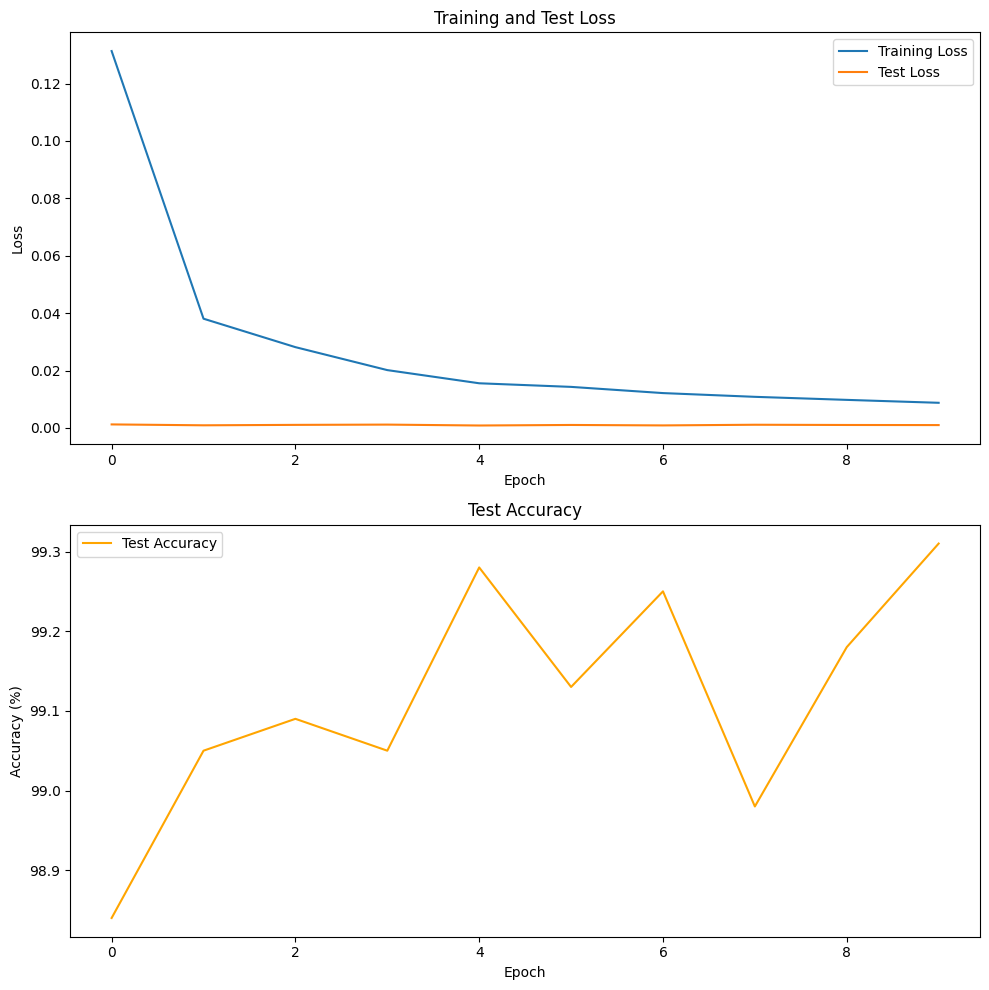

In [14]:
# 손실 및 정확도 시각화
fig, axs = plt.subplots(2,1,figsize=(10,10))
axs[0].plot(train_losses, label = 'Training Loss')
axs[0].plot(test_losses, label = 'Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Test Accuracy')

plt.tight_layout()
plt.show()